In [67]:
import tensorflow as tf
import lime
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
from PIL import Image
import lime
from lime import lime_image

dataset github link  -> https://github.com/OmdenaAI/omdena-kenya-foodsecurity/tree/main/src/data/data-crop-disease-prediction
Dataset used -> Crop Disease Prediction - Dataset(4),

In [3]:
for dirpath,dirname,filename in os.walk('Corn_Disease_Prediction'):
    print(f"There are {len(dirname)} directories and {len(filename)} images in {dirpath}.")

There are 2 directories and 0 images in Corn_Disease_Prediction.
There are 4 directories and 0 images in Corn_Disease_Prediction\test.
There are 0 directories and 228 images in Corn_Disease_Prediction\test\Blight.
There are 0 directories and 261 images in Corn_Disease_Prediction\test\Common_Rust.
There are 0 directories and 115 images in Corn_Disease_Prediction\test\Grey_Leaf_Spot.
There are 0 directories and 232 images in Corn_Disease_Prediction\test\Healthy.
There are 4 directories and 0 images in Corn_Disease_Prediction\train.
There are 0 directories and 918 images in Corn_Disease_Prediction\train\Blight.
There are 0 directories and 1045 images in Corn_Disease_Prediction\train\Common_Rust.
There are 0 directories and 459 images in Corn_Disease_Prediction\train\Grey_Leaf_Spot.
There are 0 directories and 930 images in Corn_Disease_Prediction\train\Healthy.


In [4]:
import pathlib

data_dir = pathlib.Path('Corn_Disease_Prediction/train')
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['Blight' 'Common_Rust' 'Grey_Leaf_Spot' 'Healthy']


In [5]:
len(class_names)

4

In [6]:
# Picking a random image for visualization

def view_random_image(file_path,class_name):
    folder_path = file_path + class_name
    
    random_image = random.sample(os.listdir(folder_path),1)
    print(random_image)
    
    img = cv2.imread(folder_path + '/' + random_image[0])
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
    
    print(f"Shape of image is {img.shape}")
    
    return img

['Corn_Blight (112).JPG']
Shape of image is (256, 256, 3)


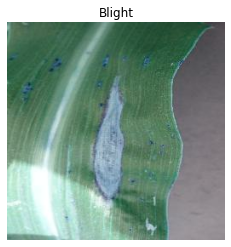

In [8]:
img = view_random_image("Corn_Disease_Prediction/train/","Blight")

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Image Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [11]:
train_dir = 'Corn_Disease_Prediction/train'
test_dir = 'Corn_Disease_Prediction/test'

In [12]:
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                              batch_size = 32,
                                              target_size = (224,224),
                                              class_mode = 'categorical',
                                              seed = 42)

test_data = test_datagen.flow_from_directory(directory = test_dir,
                                              batch_size = 32,
                                              target_size = (224,224),
                                              class_mode = 'categorical',
                                              seed = 42)

Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


Creating the baseline model

In [41]:
tf.random.set_seed(42)

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(30,3,activation = tf.keras.activations.relu , input_shape = (224,224,3)),
    tf.keras.layers.Conv2D(30,3,activation = tf.keras.activations.relu),
    tf.keras.layers.Conv2D(30,3,activation = tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(pool_size = 2 , padding = 'same'),
    tf.keras.layers.Conv2D(30,3,activation = tf.keras.activations.relu),
    tf.keras.layers.Conv2D(30,3,activation = tf.keras.activations.relu),
    tf.keras.layers.Conv2D(30,3,activation = tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(pool_size = 2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4,activation = tf.keras.activations.softmax)
])

model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
105/105 [==============================] - 330s 3s/step - loss: 0.5937 - accuracy: 0.7637 - val_loss: 0.7763 - val_accuracy: 0.7033
Epoch 2/5
105/105 [==============================] - 339s 3s/step - loss: 0.3761 - accuracy: 0.8511 - val_loss: 0.4343 - val_accuracy: 0.8170
Epoch 3/5
105/105 [==============================] - 340s 3s/step - loss: 0.3421 - accuracy: 0.8672 - val_loss: 0.4440 - val_accuracy: 0.8134
Epoch 4/5
105/105 [==============================] - 340s 3s/step - loss: 0.4935 - accuracy: 0.8377 - val_loss: 0.5746 - val_accuracy: 0.7775
Epoch 5/5
105/105 [==============================] - 340s 3s/step - loss: 0.2838 - accuracy: 0.8917 - val_loss: 0.5055 - val_accuracy: 0.8313


In [42]:
model_1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 222, 222, 30)      840       
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 220, 220, 30)      8130      
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 218, 218, 30)      8130      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 109, 109, 30)      0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 107, 107, 30)      8130      
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 105, 105, 30)      8130      
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 103, 103, 30)     

In [43]:
model_df = pd.DataFrame(history_1.history)

In [44]:
model_df

,loss,accuracy,val_loss,val_accuracy
0,0.593650,0.763723,0.776302,0.703349
1,0.376115,0.851134,0.434274,0.816986
2,0.342086,0.867243,0.444043,0.813397
3,0.493538,0.837709,0.574633,0.777512
4,0.283812,0.891706,0.505542,0.831340


<AxesSubplot:>

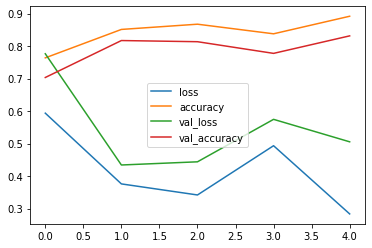

In [45]:
model_df.plot()

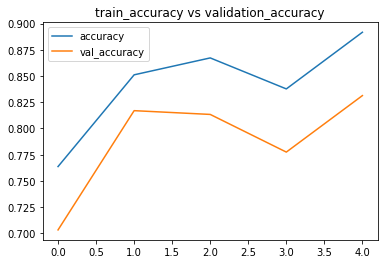

In [46]:
plt.plot(model_df['accuracy'],label = "accuracy")
plt.plot(model_df['val_accuracy'],label = "val_accuracy")
plt.title("train_accuracy vs validation_accuracy")
plt.legend()

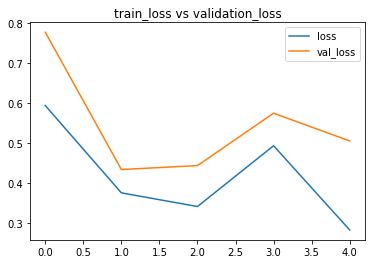

In [47]:
plt.plot(model_df['loss'],label = "loss")
plt.plot(model_df['val_loss'],label = "val_loss")
plt.title("train_loss vs validation_loss")
plt.legend()

In [48]:
model_1.evaluate(test_data)

27/27 [==============================] - 16s 597ms/step - loss: 0.5055 - accuracy: 0.8313


[0.5055420994758606, 0.8313397169113159]

[[0. 0. 1. 0.]]
Grey_Leaf_Spot


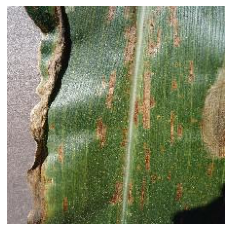

In [49]:
test_img = Image.open("Corn_Disease_Prediction/test/Grey_Leaf_Spot/Corn_Gray_Spot (461).jpg")
test_img = np.array(test_img.convert("RGB"))
test_img = cv2.resize(test_img,(224,224),interpolation = cv2.INTER_NEAREST)
plt.imshow(test_img)
plt.axis("off")
test_img = np.expand_dims(test_img,axis=0)
prediction = model_1.predict(test_img)
prediction_cls = np.argmax(prediction)
print(prediction)
print(class_names[prediction_cls])

[[1.000000e+00 1.845239e-32 0.000000e+00 0.000000e+00]]
Blight


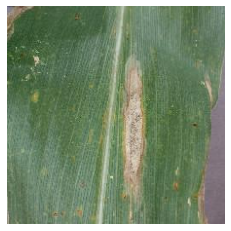

In [53]:
test_img_1 = Image.open("Corn_Disease_Prediction/test/Blight/Corn_Blight (919).jpg")
test_img_1 = np.array(test_img_1.convert("RGB"))
test_img_1= cv2.resize(test_img_1,(224,224),interpolation = cv2.INTER_NEAREST)
plt.imshow(test_img_1)
plt.axis("off")
test_img_1 = np.expand_dims(test_img_1,axis=0)
prediction = model_1.predict(test_img_1)
prediction_cls = np.argmax(prediction)
print(prediction)
print(class_names[prediction_cls])

[[0. 0. 0. 1.]]
Healthy


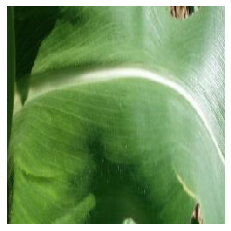

In [54]:
test_img_2 = Image.open("Corn_Disease_Prediction/test/Healthy/Corn_Health (932).jpg")
test_img_2 = np.array(test_img_2.convert("RGB"))
test_img_2= cv2.resize(test_img_2,(224,224),interpolation = cv2.INTER_NEAREST)
plt.imshow(test_img_2)
plt.axis("off")
test_img_2 = np.expand_dims(test_img_2,axis=0)
prediction = model_1.predict(test_img_2)
prediction_cls = np.argmax(prediction)
print(prediction)
print(class_names[prediction_cls])

In [55]:
def find_true_class(file_path):
    true_class = None
    for x in class_names:
        if x in file_path:
            true_class = x
    
    return true_class

In [72]:
from skimage.segmentation import mark_boundaries

Visualization using lime image explainer

In [73]:
def visualize(file_path,ax,text_loc):
    test_image = Image.open(file_path)
    test_image = np.array(test_image.convert("RGB"))
    test_image = cv2.resize(test_image,(224,224),interpolation=cv2.INTER_NEAREST)
    test_image = np.expand_dims(test_image,axis=0)
    probs = model_1.predict(test_image)
    pred_class = np.argmax(probs)
    pred_class = class_names[pred_class]

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(test_image[0], model_1.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)


    ax.imshow(mark_boundaries(temp, mask))
    fig.text(text_loc, 0.9, "Predicted Class: " + pred_class , fontsize=13)
    true_class = find_true_class(file_path)
    if true_class is not None:
        fig.text(text_loc, 0.86, "Actual Class: " + true_class , fontsize=13)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

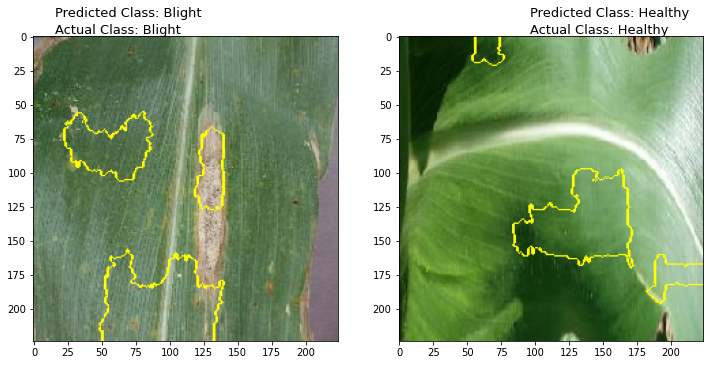

In [80]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
visualize('Corn_Disease_Prediction/test/Blight/Corn_Blight (919).jpg',ax[0],0.15)
visualize('Corn_Disease_Prediction/test/Healthy/Corn_Health (932).jpg',ax[1],0.7)

In [81]:
model_1.save("Corn_model_1.h5")

GPU used for training the model

In [82]:
!nvidia-smi

Sun Sep 19 19:27:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.96       Driver Version: 471.96       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8    N/A /  N/A |    177MiB /  4096MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------